In [1]:
import bigbench
bigbench_path = bigbench.__path__[0]

In [2]:
from bigbench.api import task
from bigbench.api import results
import os
TASK_DATA = results.load_results(path=os.path.join(bigbench_path,'benchmark_tasks'))
ALL_TASKS = sorted(TASK_DATA.keys())
import glob
import json
import pandas as pd

data_rows = []
preferred_data_rows = []

def safe_retrieve(fn):
    try:
        return fn()
    except:
        return None

for t, td in TASK_DATA.items():
    for f in glob.glob(f"../bigbench/benchmark_tasks/{t}/results/*.json"):
        with open(f, 'r') as fp:
            data = json.load(fp)
        
        model = f"{data['model']['model_family']}_{data['model']['model_name']}".replace(" ", "_")
        temperature = safe_retrieve(lambda: data['model']['decoding_params']['temperature'])
        non_embedding_params = data['model']['non_embedding_params']
        total_params = data['model']['total_params']
        training_batch_size = data['model']['training_batch_size']
        training_steps = data['model']['training_steps']
        
        for scored in data['scores']:
            st = scored['subtask_description']
            pref_rank_fn = scored['preferred_score']
            shot = scored['number_of_shots']
            if pref_rank_fn is not None:
                preferred_data_rows.append([
                    t, st, pref_rank_fn, model, shot, temperature, non_embedding_params,
                    total_params, training_batch_size, training_steps, scored['score_dict'][pref_rank_fn]
                ])

            for rank_fn, score in scored['score_dict'].items():
                data_rows.append([
                    t, st, rank_fn, model, shot, temperature, non_embedding_params,
                    total_params, training_batch_size, training_steps, score
                ])

df = pd.DataFrame(data_rows, columns=[
    'task', 'subtask_description', 'rank_function', 'model', 'number_of_shots',
    'temperature', 'non_embedding_params', 'total_params', 'training_batch_size',
    'training_steps', 'score'
])
preferred_df = pd.DataFrame(preferred_data_rows, columns=[
    'task', 'subtask_description', 'rank_function', 'model', 'number_of_shots',
    'temperature', 'non_embedding_params', 'total_params', 'training_batch_size',
    'training_steps', 'score'
])

In [7]:
scored['score_dict']

{'bleu': 0.09743664542745699,
 'bleurt': 0.1504780386967468,
 'case_insensitive_str_match': 0.0,
 'exact_str_match': 0.0,
 'log_likelihood': -94.521484375,
 'normalized_aggregate_score': 0.09743664542745699,
 'numeric_match_with_0_1_relative_error': 0.0,
 'rouge1': 2.583120704673241,
 'rouge2': 0.060979920814479636,
 'rougeLsum': 2.554004235308112,
 'sequence_f1': 0.0677333733974359}

In [3]:
# Define the output CSV file path
preferred_df.to_csv("../csvs/bigbench_newschema_preferred.csv", index=False)
df.to_csv("../csvs/bigbench_newschema.csv", index=False)


In [4]:
# TASK_DATA[ALL_TASKS[0]].data['abstract_narrative_understanding:4_distractors']['calibration_multiple_choice_brier_score']['GPT']
records = "../csvs/bigbench_newschema_preferred.csv"
import pandas as pd

df = pd.read_csv(records)

/mnt/sdd1/atharvas/env/miniconda3/envs/bigbench/lib/python3.10/site-packages/seaborn/distributions.py:267: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  baselines[cols] = curves[cols].shift(1, axis=1).fillna(0)


<Axes: xlabel='Count', ylabel='rank_function'>

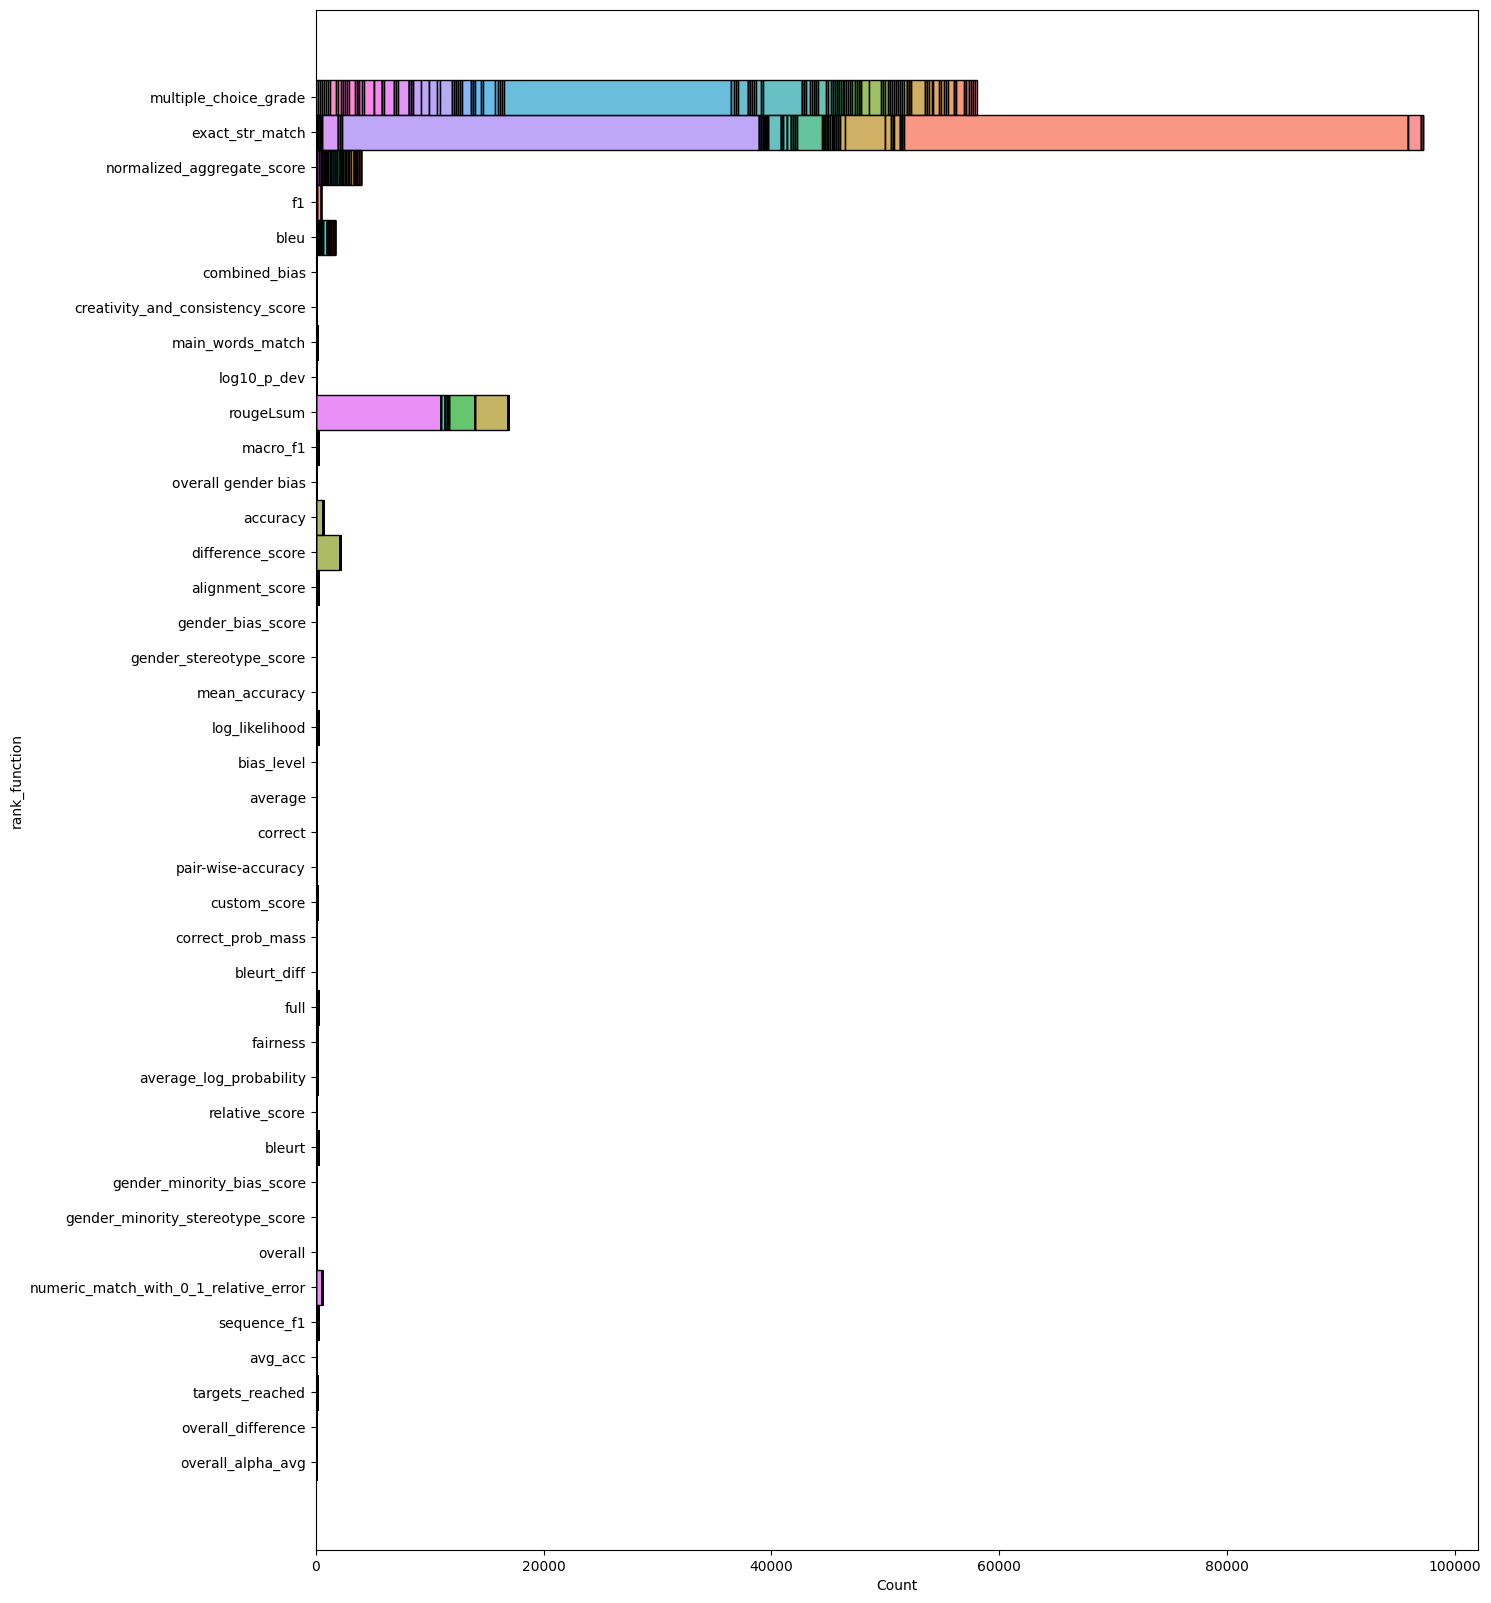

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 20))

sns.histplot(data=preferred_df, y='rank_function', ax=ax, hue='task', multiple='stack', legend=False)
# preferred_df['rank_function'].hist(rwidth=0.8, xrot=90, figsize=(30, 5), bins=preferred_df['rank_function'].nunique())

In [6]:
str_match_df = preferred_df[preferred_df['rank_function'] == 'exact_str_match'].drop(columns=['rank_function'])
str_match_df.to_csv("../csvs/bigbench_newschema_preferred_str_match.csv", index=False)

mcq_grade_df = preferred_df[preferred_df['rank_function'] == 'multiple_choice_grade'].drop(columns=['rank_function'])
mcq_grade_df.to_csv("../csvs/bigbench_newschema_preferred_mcq_grade.csv", index=False)